In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [7]:
physical_devices = tf.config.list_physical_devices( 'GPU')
print(physical_devices)
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Data Loading Function

In [8]:
import gdown
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall( 'data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=0086b16a-cae9-43ef-a811-363f33a8a791
To: /Users/maniksinghsarmaal/Downloads/Computer_Vision/Projects/lip_reading/data.zip
100%|██████████| 423M/423M [00:27<00:00, 15.5MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [10]:
def load_video(path: str) -> List[float]:
    
    cap =cv2.VideoCapture(path)
    frames =[]
    for _ in range (int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32)/std

In [11]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [14]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary= char_to_num.get_vocabulary(), oov_token="", invert= True)
print(
    f"The vocabulary size is: {char_to_num.get_vocabulary()}"
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulary size is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size = 40)


In [16]:
def load_alignments(path: str) -> List[str]:
    with open(path,'r') as f:
        lines = f.readlines()
    tokens =[]
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [38]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [39]:
test_path = '/Users/maniksinghsarmaal/Downloads/Computer_Vision/Projects/lip_reading/data/s1/bbas3a.mpg'

In [40]:
tf.convert_to_tensor(test_path)

<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/maniksinghsarmaal/Downloads/Computer_Vision/Projects/lip_reading/data/s1/bbas3a.mpg'>

In [42]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

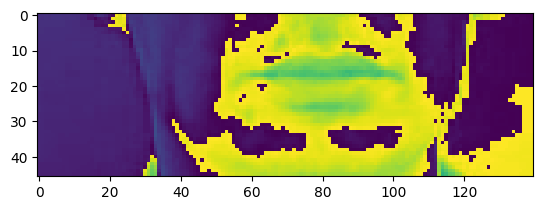

In [46]:
plt.imshow(frames[5])

In [47]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

Create Data Pipeline

In [48]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [66]:
frames, alignments = data.as_numpy_iterator().next()
len(frames)

2

In [67]:
alignments

array([[12,  1, 25, 39,  2, 12, 21,  5, 39,  9, 14, 39, 17, 39, 15, 14,
         5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14, 39,  7, 18,  5,  5, 14, 39, 23,  9, 20,  8, 39, 21,
        39, 19,  9, 24, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [71]:
test = data.as_numpy_iterator()
val = test.next(); val[0]

array([[[[[1.2163087 ],
          [1.2163087 ],
          [1.1782991 ],
          ...,
          [0.4941254 ],
          [0.60815436],
          [0.38009647]],

         [[1.2163087 ],
          [1.2163087 ],
          [1.1782991 ],
          ...,
          [0.45611575],
          [0.60815436],
          [0.34208682]],

         [[1.0642701 ],
          [1.0642701 ],
          [1.0642701 ],
          ...,
          [0.38009647],
          [0.87422186],
          [0.68417364]],

         ...,

         [[0.7982026 ],
          [0.7982026 ],
          [0.7982026 ],
          ...,
          [8.400132  ],
          [7.9060063 ],
          [8.324113  ]],

         [[0.7221833 ],
          [0.7221833 ],
          [0.7221833 ],
          ...,
          [9.046296  ],
          [7.3738713 ],
          [8.134065  ]],

         [[0.7221833 ],
          [0.7221833 ],
          [0.7221833 ],
          ...,
          [9.65445   ],
          [7.2598424 ],
          [7.601929  ]]],


        [[[1.0642

In [72]:
array_reshaped = val[0][1].squeeze()  # Remove the last dimension
array_uint8 = (array_reshaped * 255).astype(np.uint8)  # Convert to uint8 data type

# Save the animation
imageio.mimsave('./animation.gif', array_uint8, fps=10)

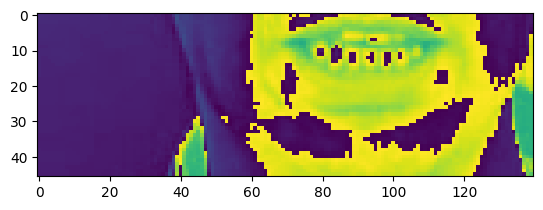

In [77]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][28])

In [79]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay red at y seven again'>

Design a Deep Neural Network

In [80]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [81]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [82]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [83]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [86]:
#Random checking without trainiing lol :)
yhat = model.predict(val[0])
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

1/1 [==============================] - 7s 7s/step


<tf.Tensor: shape=(), dtype=string, numpy=b'5ttt33p333333333???????????????????????????????3333????????????3ttttttaaaaa'>

In [87]:
def scheduler(epoch, lr):
    if epoch <30:
        return lr
    else:
        return lr* tf.math.exp(-0.1)

In [88]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [89]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [91]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [93]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [94]:
schedule_callback = LearningRateScheduler(scheduler)

In [96]:
example_callback = ProduceExample(data)

In [97]:
model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/50
 25/450 [>.............................] - ETA: 3:42:16 - loss: 133.0952